In [2]:
# 1. Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 2. Load Data
data = pd.read_csv('Telco-Customer-Churn.csv')  # Adjust path to dataset file

In [6]:
# 3. Exploratory Data Analysis (EDA)
print(data.head())
print(data.info())
print(data.describe())
print(data['Churn'].value_counts())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

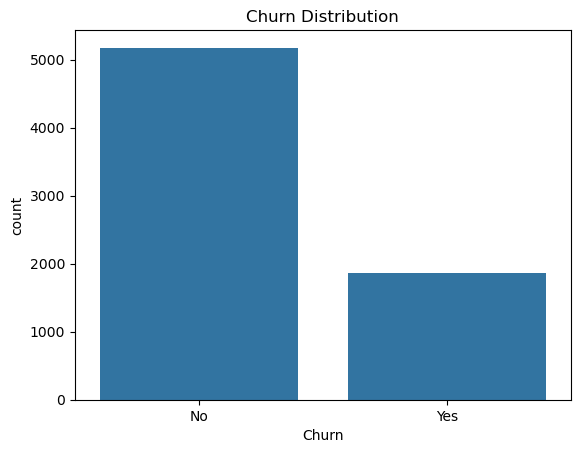

In [8]:
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

In [10]:
# Check missing values
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [49]:
data[data["TotalCharges"]==" "]
len(data[data["TotalCharges"]==" "])
data["TotalCharges"] = data["TotalCharges"].replace({" ": "0.0"})
data["TotalCharges"] = data["TotalCharges"].astype(float)

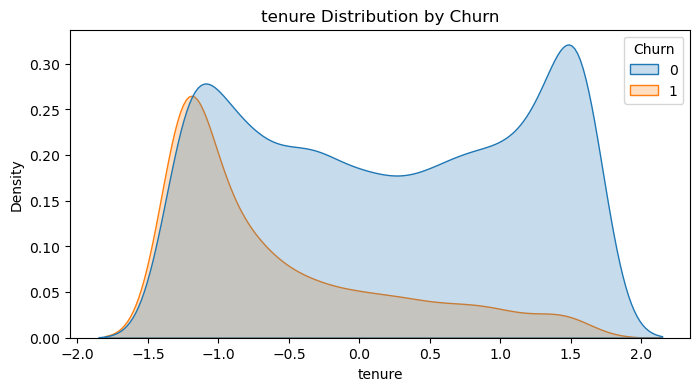

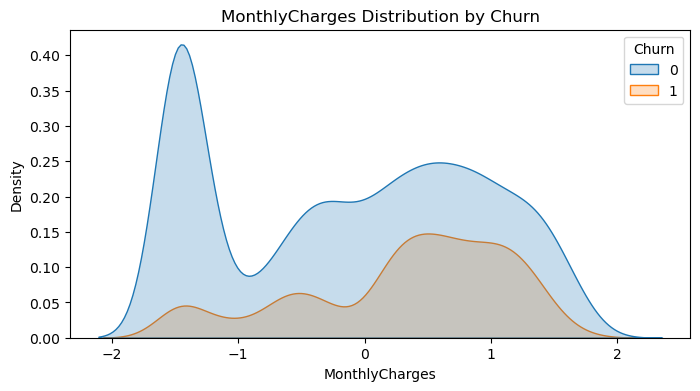

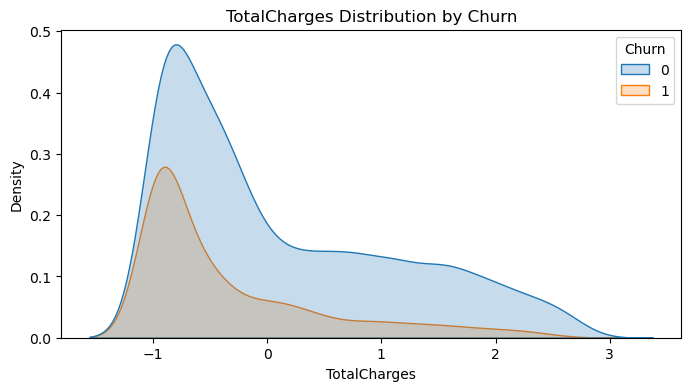

In [51]:
# Visualize numeric feature distributions by churn
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for feature in num_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=data, x=feature, hue='Churn', shade=True)
    plt.title(f'{feature} Distribution by Churn')
    plt.show()

In [14]:
# 4. Preprocessing & Feature Engineering

# Convert TotalCharges to numeric and fill missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [16]:
# Drop customerID as it's an identifier
data.drop('customerID', axis=1, inplace=True)

In [18]:
# Encode categorical variables by one-hot encoding except target
cat_cols = data.select_dtypes(include=['object']).columns.drop('Churn')
data = pd.get_dummies(data, columns=cat_cols)

In [20]:
# Encode target variable
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})


In [22]:
# Scale numerical features
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])


In [24]:
# Separate features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

In [26]:
# 5. Handle Imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [28]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [30]:
# 7. Model Training with Hyperparameter Tuning - Random Forest
rf = RandomForestClassifier(random_state=42)

In [32]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [34]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [36]:
best_rf = grid_search.best_estimator_

In [38]:
# 8. Model Evaluation
y_pred = best_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.8517
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.84      0.87      0.85      1035

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



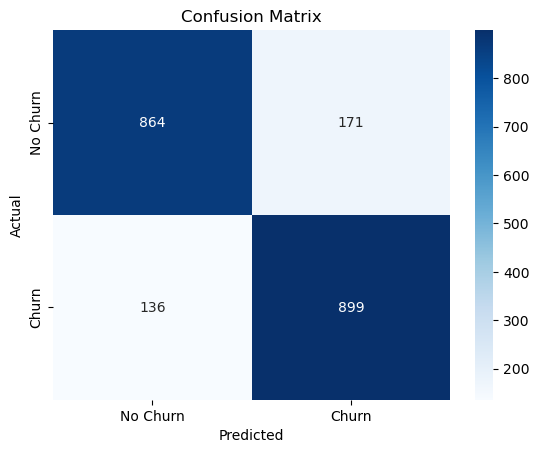

In [40]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# 9. Cross-validation for robustness
cv_scores = cross_val_score(best_rf, X_res, y_res, cv=5, scoring='accuracy')
print(f'Cross-validated accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}')


Cross-validated accuracy: 0.8600 +/- 0.0474


In [44]:
# 10. Feature Importance Visualization
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns


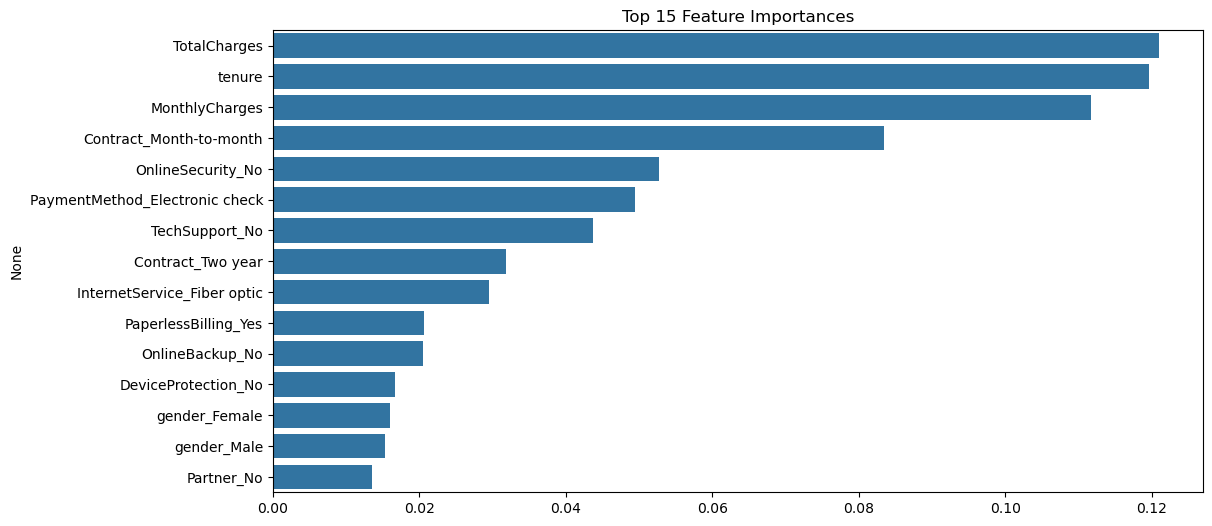

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices][:15], y=features[indices][:15])
plt.title('Top 15 Feature Importances')
plt.show()